In [10]:
"""
now it's only a skeleton of a classifier
TODO: 
- test different numbers and different lengths of shapelets
- use better distance metric than euclidean, maybe dtw
- choosing shapelets which are not full 178-dimensional samples, but their subsequences
- choose shapelets not randomly
- ...

- (I couldn't use a library implementation of the Shapelets either from tslearn or sktime. It seems 
   that you need to have some old versions of these extensions to use them.)
"""

"\nnow it's only a skeleton of a classifier\nTODO: \n- test different numbers and different lengths of shapelets\n- use better distance metric than euclidean, maybe dtw\n- choosing shapelets which are not full 178-dimensional samples, but their subsequences\n- choose shapelets not randomly\n- ...\n\n- (I couldn't use a library implementation of the Shapelets either from tslearn or sktime. It seems \n   that you need to have some old versions of these extensions to use them.)\n"

In [11]:
from preprocess import get_prepared_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

In [12]:
# Load preprocessed, prepared data with original labels
# We want to divide the data into original 5 classes
# And change the shape to (n_samples, 178, 1) because DTW requires 3-dimensional vectors
X, y = get_prepared_data(oversample=False, relabel=False)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
"""
This class implements a classifier based on Shapelets, which are subsequences 
of time series data with distinctive patterns.

The purpose of the classifier is to identify these subsequences that best represent
 patterns characteristic of different classes in the dataset.
"""

class ImprovedShapeletClassifier:

    # Initialize Shapelet classifier
    def __init__(self, n_shapelets=10, shapelet_lengths=None):
        self.n_shapelets = n_shapelets       #  number of shapelets
        self.shapelet_lengths = shapelet_lengths if shapelet_lengths else [10, 20, 30]
        self.shapelets = None                #  here we store the selected shapelets
        self.shapelet_labels = None          #  labels assigned to each shapelet
        self.classes_ = None                 #  unique class labels

    def _extract_random_shapelets(self, X, y, lengths):
        shapelets = []
        shapelet_labels = []
        for length in lengths:
            for _ in range(self.n_shapelets // len(lengths)):
                series_idx = np.random.randint(0, X.shape[0])
                start_idx = np.random.randint(0, X.shape[1] - length)
                
                # extract subsequence (shapelet)
                shapelet = X[series_idx, start_idx:start_idx + length, :]
                shapelets.append(shapelet)
                shapelet_labels.append(y[series_idx])
        
        # keep the shapelets as lists because they have different lengths
        return shapelets, shapelet_labels
    
    def fit(self, X, y):
        np.random.seed(42)
        self.classes_ = np.unique(y)
        
        # Extract random shapelets
        self.shapelets, self.shapelet_labels = self._extract_random_shapelets(X, y, self.shapelet_lengths)


    # Train the classifier by choosing shapelets and assigning classes to them
    # X with shape (n_samples, series_length, 1)
    def fit2(self, X, y):
        np.random.seed(42)
        self.classes_ = np.unique(y)
        n_samples, series_length, _ = X.shape
        
        # randomly select shapelets
        shapelet_indices = np.random.choice(n_samples, self.n_shapelets, replace=False)
        self.shapelets = X[shapelet_indices]
        
        # assign labels to shapelets based on nearest samples
        self.shapelet_labels = y[shapelet_indices]

    
    '''
    # Compute the Euclidean distance between the time series sample X shape and the Shapelet (with shape (series_length, 1))
    def _distance_to_shapelet(self, X, shapelet):
        distances = np.sqrt(np.sum((X - shapelet) ** 2, axis=1))
        return np.min(distances)
    '''
    
    # Compute the Euclidean distance between the time series sample X shape and the Shapelet (with shape (series_length, 1))
    def _distance_to_shapelet(self, X, shapelet):
        shapelet_length = len(shapelet)
        distances = []

        # slide the shapelet over all possible subsequences of the same length in X
        for i in range(len(X) - shapelet_length + 1):
            subsequence = X[i:i + shapelet_length]
            distance = np.sqrt(np.sum((subsequence - shapelet) ** 2))  # euclidean distance
            distances.append(distance)

        # return the minimum distance
        return min(distances)


    # Predict 
    def predict(self, X):
        n_samples, series_length, _ = X.shape
        predictions = []

        # compute the distance of each sample to each Shapelet
        for sample in X:
            distances = [self._distance_to_shapelet(sample, shapelet) for shapelet in self.shapelets]
            
            # Find the shapelet with minimum distance and assign it as a predicted label for the sample
            closest_shapelet_idx = np.argmin(distances)
            predictions.append(self.shapelet_labels[closest_shapelet_idx])
 
        return np.array(predictions)


In [14]:
# I tested [10, 20, 30], [15, 25, 50], [20, 30, 60], [20; 40; 60; 80], [40, 60, 80], [42, 69, 100]
# and for n_shapelets: 50, 69 (32,8%), 100 (33,59%), 200 (35,79%)
shapelet_clf = ImprovedShapeletClassifier(n_shapelets=200, shapelet_lengths=[40, 60, 80])

# Training classifier
shapelet_clf.fit(X_train, y_train)

# Prediction
y_pred = shapelet_clf.predict(X_test)



Accuracy: 0.35792709705753184
Precision: 0.48092219929576463
Recall: 0.35792709705753184

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.39      0.56       456
           2       0.26      0.40      0.32       455
           3       0.27      0.45      0.34       455
           4       0.54      0.21      0.31       456
           5       0.33      0.33      0.33       455

    accuracy                           0.36      2277
   macro avg       0.48      0.36      0.37      2277
weighted avg       0.48      0.36      0.37      2277


[[178  83 122  46  27]
 [  0 184 195   9  67]
 [  0 177 203   5  70]
 [  0 105 104  98 149]
 [  0 161 120  22 152]]


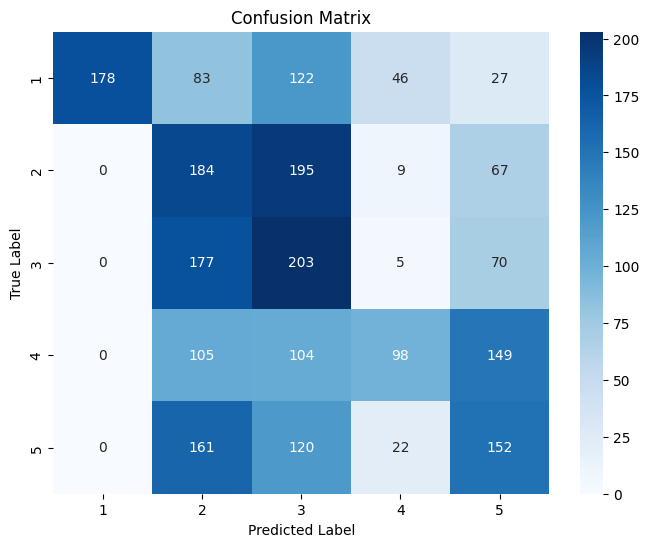

In [17]:
# Evaluation of the results
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print()
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=shapelet_clf.classes_, yticklabels=shapelet_clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
